In [9]:
import os
import sys
script_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(script_dir, '..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [19]:
from model import LII_LSTM, Distiller_LII_LSTM
import torch
from torch import nn
from torch.utils import data as data_utils
import distiller
from distiller.modules import DistillerLSTM as LSTM
from tqdm import tqdm # for pretty progress bar
import numpy as np
import torchvision
import collections
import matplotlib.pyplot as plt

In [11]:
# Set up device and manual seed
torch.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading the model.

In [12]:
rnn_model = torch.load('../golden_data/20190428_checkpoint.pth.tar.best')
rnn_model = rnn_model.to(device)
rnn_model

LII_LSTM(
  (rnn): LSTM(1, 12)
  (linear): Linear(in_features=12, out_features=1, bias=True)
)

In [55]:
def to_np(x):
    return x.cpu().numpy()

def flatten(weights):
    weights = weights.clone().view(weights.numel())
    weights = to_np(weights)
    return weights


import scipy.stats as stats
def plot_params_hist_single(name, weights_pytorch, remove_zeros=False, kmeans=None):
    weights = flatten(weights_pytorch)
    if remove_zeros:
        weights = weights[weights!=0]
    n, bins, patches = plt.hist(weights, bins=200)
    plt.title(name)
    
    if kmeans is not None:
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        cnt_coefficients = [len(labels[labels==i]) for i in range(16)]
        # Normalize the coefficients so they display in the same range as the float32 histogram
        cnt_coefficients = [cnt / 5 for cnt in cnt_coefficients] 
        centroids, cnt_coefficients = zip(*sorted(zip(centroids, cnt_coefficients)))
        cnt_coefficients = list(cnt_coefficients)
        centroids = list(centroids)
        if remove_zeros:
            for i in range(len(centroids)):
                if abs(centroids[i]) < 0.0001:  # almost zero
                    centroids.remove(centroids[i])
                    cnt_coefficients.remove(cnt_coefficients[i])
                    break
        
        plt.plot(centroids, cnt_coefficients)
        zeros = [0] * len(centroids)
        plt.plot(centroids, zeros, 'r+', markersize=15)
        
        h = cnt_coefficients
        hmean = np.mean(h)
        hstd = np.std(h)
        pdf = stats.norm.pdf(h, hmean, hstd)
        #plt.plot(h, pdf)
        
    plt.show()
    print("mean:{:.1f}\nstddev:{:.1f}".format(weights.mean().item(), weights.std().item()))
    print("size={}".format(distiller.size2str(weights_pytorch.size())))
    print("min:{:.3f}\nmax:{:.3f}".format(weights.min().item(), weights.max().item()))

    


def plot_layer_sizes(which, sparse_model, dense_model):
    dense = []
    sparse = []
    names = []
    for name, sparse_weights in sparse_model.state_dict().items():
        if ('weight' not in name) or (which!='*' and which not in name):
                continue    
        sparse.append(len(sparse_weights[sparse_weights!=0]))
        names.append(name)

    for name, dense_weights in dense_model.state_dict().items():
        if ('weight' not in name) or (which!='*' and which not in name):
                continue
        dense.append(dense_weights.numel())

    N = len(sparse)
    ind = np.arange(N)    # the x locations for the groups

    fig, ax = plt.subplots()
    width = .47
    p1 = plt.bar(ind, dense,  width = .47, color = '#278DBC')
    p2 = plt.bar(ind, sparse, width = 0.35, color = '#000099')

    plt.ylabel('Size')
    plt.title('Layer sizes')
    plt.xticks(rotation='vertical')
    plt.xticks(ind, names)
    #plt.yticks(np.arange(0, 100, 150))
    plt.legend((p1[0], p2[0]), ('Dense', 'Sparse'))

    #Remove plot borders
    for location in ['right', 'left', 'top', 'bottom']:
        ax.spines[location].set_visible(False)  

    #Fix grid to be horizontal lines only and behind the plots
    ax.yaxis.grid(color='gray', linestyle='solid')
    ax.set_axisbelow(True)
    plt.show()
    

def fc_param_names(model):
    return [param_name for param_name, p in model.state_dict().items()  
            if (p.dim()==2) and ("weight" in param_name)]

In [58]:
print(fc_param_names(rnn_model))

['rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'linear.weight']


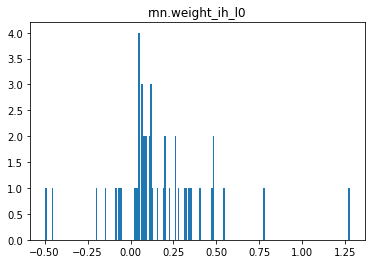

mean:0.2
stddev:0.3
size=(48, 1)
min:-0.495
max:1.275


In [56]:
plot_params_hist_single('rnn.weight_ih_l0', rnn_model.state_dict()['rnn.weight_ih_l0'])

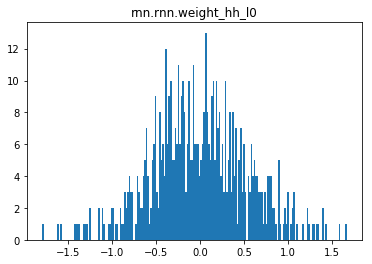

mean:-0.0
stddev:0.5
size=(48, 12)
min:-1.791
max:1.663


In [63]:
plot_params_hist_single('rnn.rnn.weight_hh_l0',
                        rnn_model.state_dict()['rnn.weight_hh_l0'])

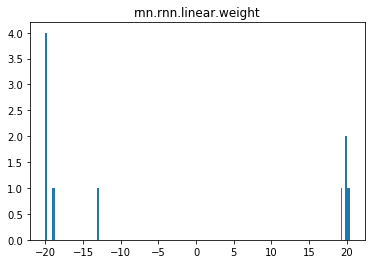

mean:-2.6
stddev:19.1
size=(1, 12)
min:-19.984
max:20.400


In [62]:
plot_params_hist_single('rnn.rnn.linear.weight', rnn_model.state_dict()['linear.weight'])